What you need: Internet connection

### What is (Web) API?

API stands for Application Programming Interface. Web API is the standard that applications should follow when communicating with each other.

Think about the Weather app on your phone. It will probably show your location, the current temperature and weather, and the forecast for the next few hours.

So the Weather app on your phone (the client side application) needs to 'pull' from the data provider e.g. weather.com (the server side application). The Weather app will send something like `{'city': 'Bristol', 'country': 'GB'}` to the server, and the server will respond with something like `{'time': '2024-11-05 16:00', 'current_temp': '10', 'current_weather': 'CLOUDY', 'forecast': {'1hr': 'CLOUDY', '2hrs': 'CLOUDY', '3hrs': 'MOSTLY_CLEAR'}}`. These are specifications of the weather API. Note that these are simplified examples.

There is a trend that data providers in the biomedical research field have been discouraging bulky download of their dataset (files) and have started rolling out their API service. Hence it's essential to learn how to interact with those APIs.

### Prep

In [1]:
import requests

from PIL import Image
from IPython.display import display

cat_base_url = "https://api.thecatapi.com/v1"

# IMPORTANT: In reality such key serves as your 'password' and should be only read from a separate file which is excluded from email attachments, file uploads and git commits etc.
# It should never be 'hardcoded' in your code.
cat_api_key = "live_J53mvL4PgbDmZHQLhdbJqOfFbLTYyxTbQ3TfgUomPwf5jDpVmRuoO2SDZcySbnX2"

ensembl_base_url = "https://rest.ensembl.org/"

def display_image(url):
    img = Image.open(requests.get(response[0]['url'], stream=True).raw)
    display(img)

### The Cat API

We will start with an interesting API service - The Cat API (yes the 'cat' is the animal). Every time you call the API endpoint, it will randomly return an instance of a cat (ID and image) from its database.

See also:
https://developers.thecatapi.com/view-account/ylX4blBYT9FaoVd6OhvR

Click 'OpenAPI Spec Doc' on the left.

In [2]:
# Get a random cat instance
r = requests.get(cat_base_url + "/images/search")
print('Request has been made to:', r.url)

response = r.json()
cat_id = response[0]['id']
cat_url = response[0]['url']

response

Request has been made to: https://api.thecatapi.com/v1/images/search


[{'id': 'arv',
  'url': 'https://cdn2.thecatapi.com/images/arv.jpg',
  'width': 612,
  'height': 612}]

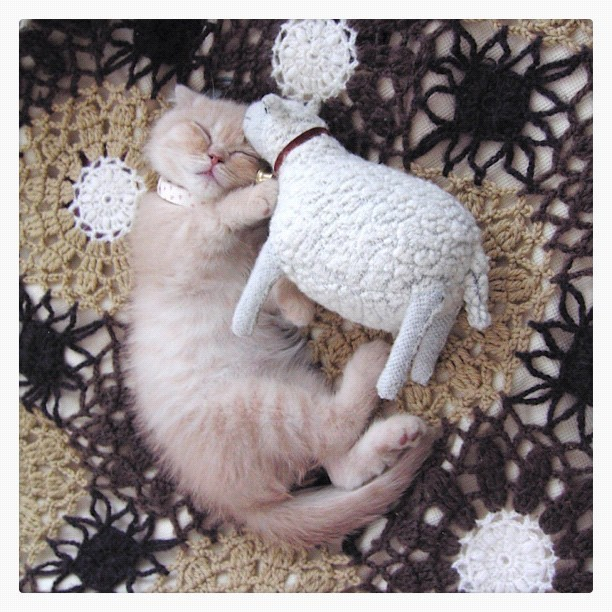

In [3]:
display_image(cat_url)

In [4]:
# Get the breed information of the cat we just saw
r = requests.get(cat_base_url + "/images/" + cat_id + "/breeds")
print('Request has been made to:', r.url)
response = r.json()

response

Request has been made to: https://api.thecatapi.com/v1/images/arv/breeds


[]

Run the **Get a random cat instance** and then the **Get the breed information of the cat we just saw** code blocks. You may have noticed that sometimes the second request returns an empty list `[]`.

In this context this means that cat we got in the first request has no breed information in their database.

How can we make sure that we always get a cat with bread info available?

A closer look into their documentation gives a hint:

https://developers.thecatapi.com/view-account/ylX4blBYT9FaoVd6OhvR

OpenAPI Spec Doc > Images > GET /images/search, under *QUERY PARAMETERS* there is a parameter called `has_breeds`. Obviously if we force that to `true` then bingo.



Go back to the **Get a random cat instance** section, add the query parameter, i.e. change:

```python
r = requests.get(cat_base_url + "/images/search")
```

to

```python
r = requests.get(cat_base_url + "/images/search", params={
    'has_breeds': True
})
```

and run the block. Now the **Get the breed information of the cat we just saw** will always return breed information because the cat instance we get will always have breed info. Note that the 'pool' of cats are smaller now because those without breed info will be excluded.

### The Ensembl API

Now we look at something biomedical.

In [5]:
# Get gene info using Ensembl ID

# https://rest.ensembl.org/documentation/info/lookup

ensembl_id = 'ENSG00000157764'

r = requests.get(ensembl_base_url + 'lookup/id/' + ensembl_id, headers={
    "Content-Type" : "application/json"
})

r.json()

{'species': 'homo_sapiens',
 'strand': -1,
 'start': 140719327,
 'description': 'B-Raf proto-oncogene, serine/threonine kinase [Source:HGNC Symbol;Acc:HGNC:1097]',
 'version': 14,
 'display_name': 'BRAF',
 'canonical_transcript': 'ENST00000646891.2',
 'source': 'ensembl_havana',
 'end': 140924929,
 'biotype': 'protein_coding',
 'seq_region_name': '7',
 'db_type': 'core',
 'object_type': 'Gene',
 'assembly_name': 'GRCh38',
 'logic_name': 'ensembl_havana_gene_homo_sapiens',
 'id': 'ENSG00000157764'}

#### Can we include phenotypes in the response?
Yes, as suggested by their docs, we need to add

```python
params={'phenotypes': 1}
```
as another parameter of the `requests.get()` method above. If you need to add more parameters, just add them to the same `params` parameter under the relevant keys specified by the docs.

In [6]:
# Get gene sequence (only the first 1000 bps) using Ensembl ID

ensembl_id = 'ENSG00000157764'

r = requests.get(ensembl_base_url + 'sequence/id/' + ensembl_id, headers={
    "Content-Type" : "application/json"
}, params={
    "end": 1000
})

r.json()

{'molecule': 'dna',
 'seq': 'CTTCCCCCAATCCCCTCAGGCTCGGCTGCGCCCGGGGCCGCGGGCCGGTACCTGAGGTGGCCCAGGCGCCCTCCGCCCGCGGCGCCGCCCGGGCCGCTCCTCCCCGCGCCCCCCGCGCCCCCCGCTCCTCCGCCTCCGCCTCCGCCTCCGCCTCCCCCAGCTCTCCGCCTCCCTTCCCCCTCCCCGCCCGACAGCGGCCGCTCGGGCCCCGGCTCTCGGTTATAAGATGGCGGCGCTGAGCGGTGGCGGTGGTGGCGGCGCGGAGCCGGGCCAGGCTCTGTTCAACGGGGACATGGAGCCCGAGGCCGGCGCCGGCGCCGGCGCCGCGGCCTCTTCGGCTGCGGACCCTGCCATTCCGGAGGAGGTGAGTGCTGGCGCCACCCTGCCGCCCTCCCGACTCCGGGCTCGGCGGCTGGCTGGTGTTTATTTTGGAAAGAGGCGGCGGTGGGGGCTTGATGCCCTCAGCCACCTTCTCGGGCCAGCTCCGCGGGCTGGGAGGTGGGCATCGCCCCCGTGTCCCTCTCCGTCATGCAGCGCCTTCCTACGTAAACACACACAATGGCCCGGGGGGTTTCCCTGGCCCCCACCCCAGATGTGGGGATTGGGGCAGCGGTGGTTGAGCGGGAGGCTATCAATAGGGGGCGAAACTCAGGGTTGGTCCGAGAAGGTCACGATTGGCTGAAGTATCCAGCTCTGCATCTCTGTGGGGTGGGGGCGGCGGCGGCCTCGACGTGGAGGATATAGGTTAGTTGCTGGGGCTGAGACAACAGCCCGAGTTACTGTCGCGTGTAATTCTTACATGGTCGTGGGGATGATGGGGCTCATCATTTCCTCTCTCCTCTCCCGGACTGCCCCCCTTCTCAGTCCGCTGCCCTTTTTCACTTTTCTATTTGGGGATTTCTCTTCACCTGTTTTACCCAGCAAATTATTTTGATTTAGTCTTTACTTTTTCAATCCTAAATCGCAGTTTC

### Structure of a request (simplified)

An API request can have quite a few componets, but usually the following are important:
1. Method (HTTP verb)
   - Usually `GET`, `POST`, `PUT` etc. but can be others
2. The URL ("endpoint")
   - Consists of the base URL and the endpoint path
   - e.g. `https://api.thecatapi.com/v1/images/search`, the base URL is `https://api.thecatapi.com/v1/` (usually the same for all endpoints of a service) and the endpoint path in this case is `/images/search` (varies across endpoints) - that's why we stored `cat_base_url` at the beginning for reuse and concatenated it with the different endpoints as required
3. Query Parameter (optional)
   - This is the part you will see sometimes in your browser address bar
   - The segment after `?` is the query parameter, separated by `&`, e.g. in `https://google.com/search?q=hello&language=en-GB`, the parameters will be `params={'q':'hello', 'language': 'en-GB'}` if you use Python requests package
   - In API docs it usually called **parameters**, **query parameters** etc.
4. Headers (optional)
   - They will go under the `headers={}` dict if you use Python requests package
   - In API docs it usually called **headers**
6. Body (optional)
   - They will usually go under `data={}` and/or `json={}` dict if you use Python requests package
   - - In API docs it usually called **data**, **body**, **json data** etc.

#### How to know where to put the request data?

Read their documentation. Looking for any hint such as **parameters**, **query parameters**, **headers**, **data**, **body**, **json data**.